In [1]:
import CS_functions as cs
import numpy as np
from matplotlib import pyplot as plt
from scipy import fft as spfft
from scipy.constants import speed_of_light as C
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})

In [2]:
peak_freqs = np.array([182e9, 273e9])
envelope_FWHM = 30 #mm
FWHM_freq = 40e9 # 41.497e9 # Hz. (almost?) Equivelent to 30mm FWHM envelope 
total_points = 50
pixel_pitch= 1.0 # mm
theta= 6.1 # degrees
regularization_coeffient = 1e-2
test_config = np.array([13,17,19,25,29,34,35,45])


displacement = np.arange(-(total_points//2), (total_points+1)//2) *pixel_pitch #in mm
target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta)

uncertainties = np.ones_like(target)

reduced_points = len(test_config)

detectors, score = cs.douglas_peucker(reduced_points, target, uncertainties, regularization_coeffient)
print(*detectors, sep= ",")

25,22,20,13,29,38,31,45


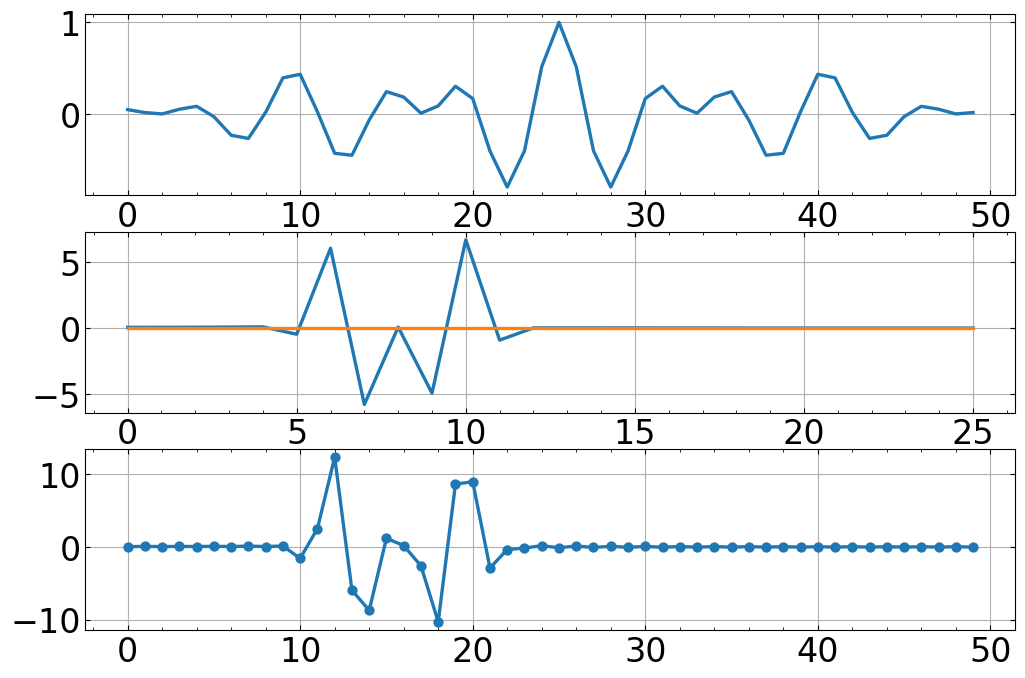

In [3]:
b = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta)
B_FFT = np.fft.rfft(b)
B_DCT = spfft.dct(b, type= 1)

fig, axs = plt.subplots(3, 1, figsize= (12, 8))

axs[0].plot(b)
axs[0].grid()

axs[1].plot(B_FFT.real)
axs[1].plot(B_FFT.imag)
axs[1].grid()

axs[2].plot(B_DCT, marker= ".")
axs[2].grid()

plt.show()

In [4]:
samples = np.full_like(target, np.nan)
samples[test_config] = target[test_config]
test_result = cs.compressed_sensing(samples, regularization_coeffient)

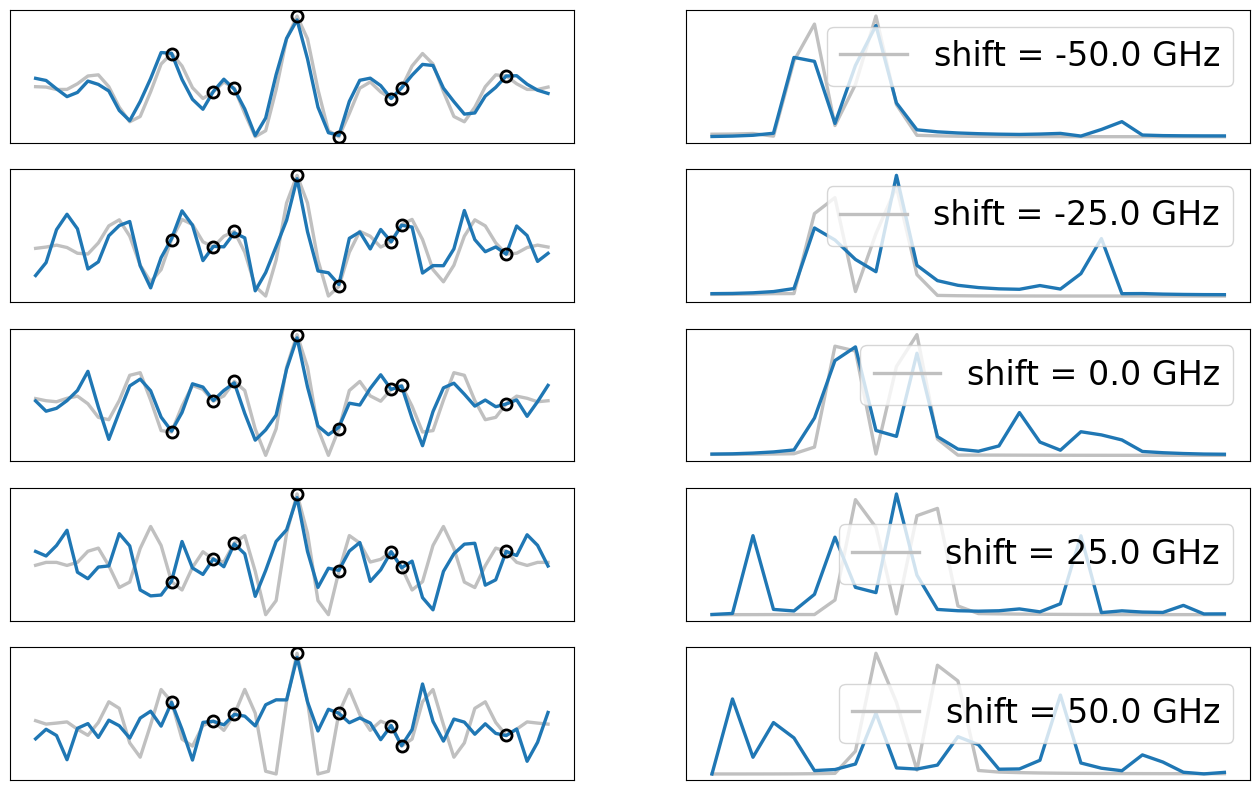

In [5]:
N = 5; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)

fig, axs = plt.subplots(N, 2, figsize= (16, 2*N))

for ax, shift in zip(axs, shifts):

    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs +shift, envelope_FWHM*1e-3, theta)

    uncertainties = np.ones_like(target)

    samples = np.full_like(target, np.nan)
    samples[test_config] = target[test_config]
    test_result = cs.compressed_sensing(samples, regularization_coeffient, norm= "ortho")

    ax[0].plot(target, color= "silver", label= "actual signal")
    ax[0].plot(test_result, color= "tab:blue", label= "")
    ax[0].plot(test_config, target[test_config], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8, label= "samples")
    ax[0].set(xticks= [], yticks= [])

    target_FFT = np.fft.rfft(target)
    target_FFT = np.abs(target_FFT)
    reconstruction_FFT = np.fft.rfft(test_result)
    reconstruction_FFT = np.abs(reconstruction_FFT)

    ax[1].plot(target_FFT, color= "silver", label= f"shift = {shift*1e-9} GHz")
    ax[1].plot(reconstruction_FFT, color= "tab:blue")
    ax[1].set(xticks= [], yticks= [])
    ax[1].legend()

plt.show()

In [6]:
test_config

array([13, 17, 19, 25, 29, 34, 35, 45])

WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data n

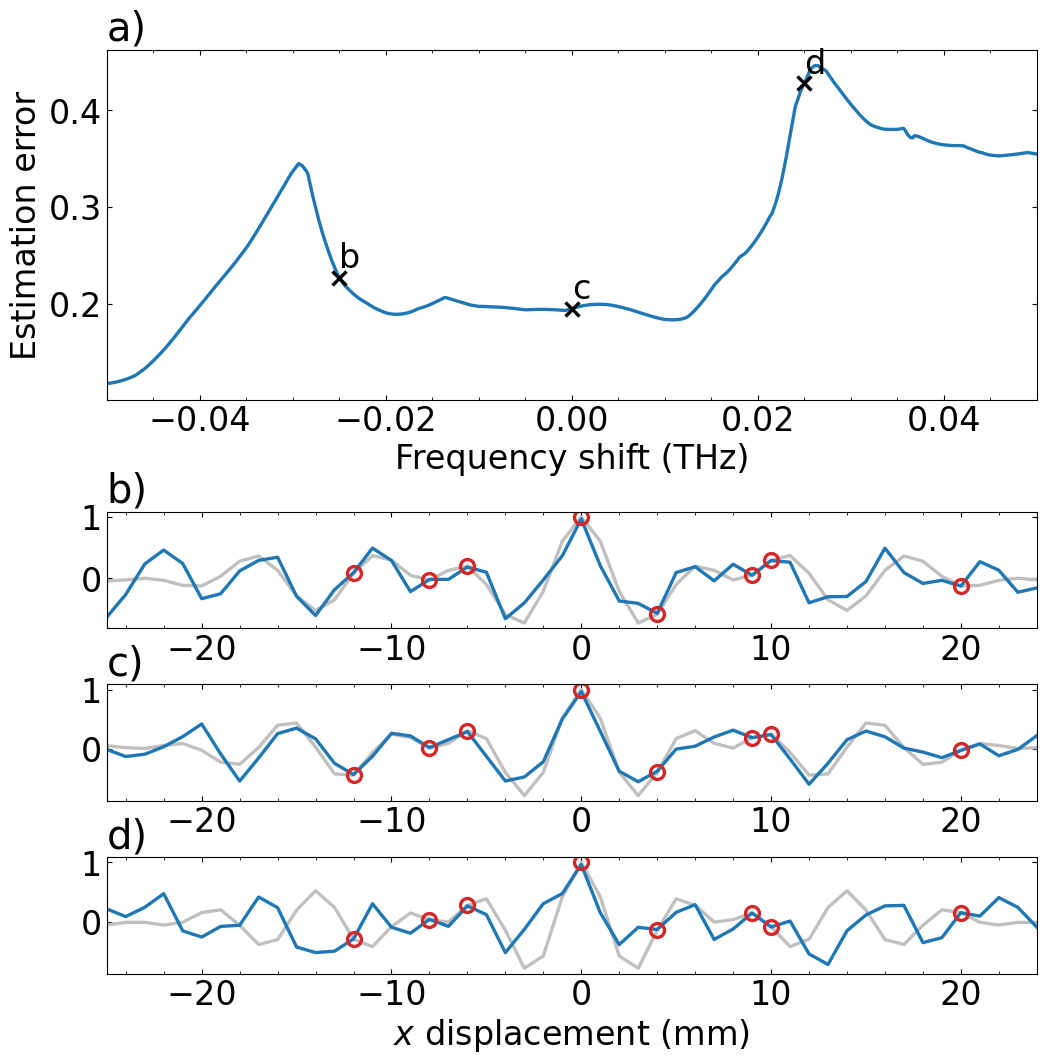

In [28]:
N = 1000; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs +shift, envelope_FWHM*1e-3, theta)

    scores[n] = cs.evaluate_score(test_config, target, regularization_coeffient= regularization_coeffient, error_type= "L2")

examples = {}
examples["shift"] = [-25e9, 0, 25e9]
examples["target"] = [cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs +shift, envelope_FWHM*1e-3, theta) for shift in examples["shift"]]
examples["uncertainty"] = [np.ones_like(target) for target in examples["target"]]
examples["score"] = [cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient= regularization_coeffient, error_type= "L2") for target, uncertainties in zip(examples["target"], examples["uncertainty"])]
examples["samples"] = [np.full_like(target, np.nan) for target in examples["target"]]
for samples, target in zip(examples["samples"], examples["target"]): samples[test_config] = target[test_config]
examples["reconstruction"] = [cs.compressed_sensing(samples, regularization_coeffient) for samples in examples["samples"]]

fig, axs = plt.subplots(5, 1, figsize= (12, 12), height_ratios= (3,0,1,1,1), gridspec_kw= {"hspace": 0.4})

axs[0].plot(shifts*1e-12, scores)
axs[0].set(xlabel= "Frequency shift (THz)", ylabel= "Estimation error", xlim= (shifts.min()*1e-12, shifts.max()*1e-12))
axs[0].set_title("a)", loc='left')

axs[1].set_axis_off()

for ax, target, reconstruction, shift, score, samples, title in zip(axs[2:], examples["target"], examples["reconstruction"], examples["shift"], examples["score"], examples["samples"], ["b)","c)","d)"]):
    ax.plot(displacement, target, color= "silver")
    ax.plot(displacement, reconstruction, color= "tab:blue")
    ax.plot(displacement, samples, linestyle= "none", marker= "o", markerfacecolor= "none", markeredgecolor= "tab:red")
    ax.set_title(title, loc= "left")
    ax.set(xlim= (displacement.min(), displacement.max()))
    axs[0].plot(shift*1e-12, score, marker= "x", color= "k")
    axs[0].text(shift*1e-12, score +0.01, title.removesuffix(")"))
axs[4].set(xlabel= "$x$ displacement (mm)")

fig.savefig("./graphs/frequency_shift_robustness.png", bbox_inches= "tight")
plt.show()


WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data n

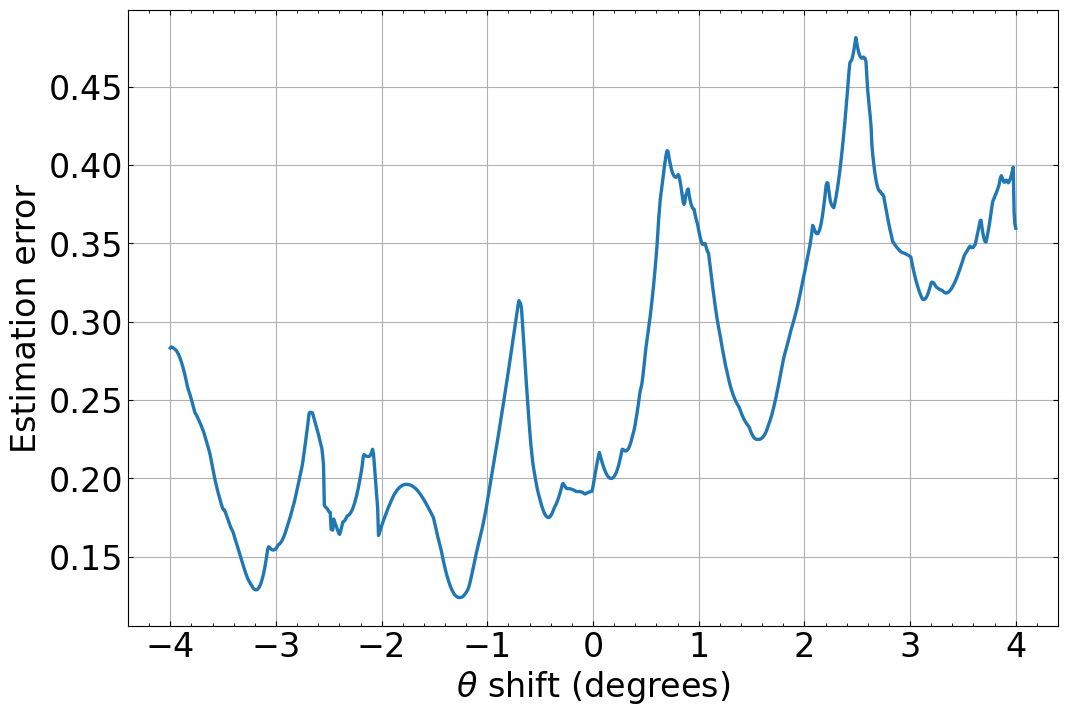

In [8]:
N = 1000; shift_range= 4.0
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta +shift)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient= regularization_coeffient, error_type= "L2")

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts, scores)
axs.set(xlabel= r"$\theta$ shift (degrees)", ylabel= "Estimation error")

plt.grid()
plt.show()


In [9]:
def closest2(x, y, x0, y0):
    idx = np.argmin(np.hypot(x -x0, y -y0))
    x1 = x[idx]
    y1 = y[idx]
    return x1, y1

11 0.045
[0.56634247 0.17288588]
0.1786065072819797 0.179689182459321
0.2857125780789578 0.28636393436564206
0.456595188123634 0.45625732552558157


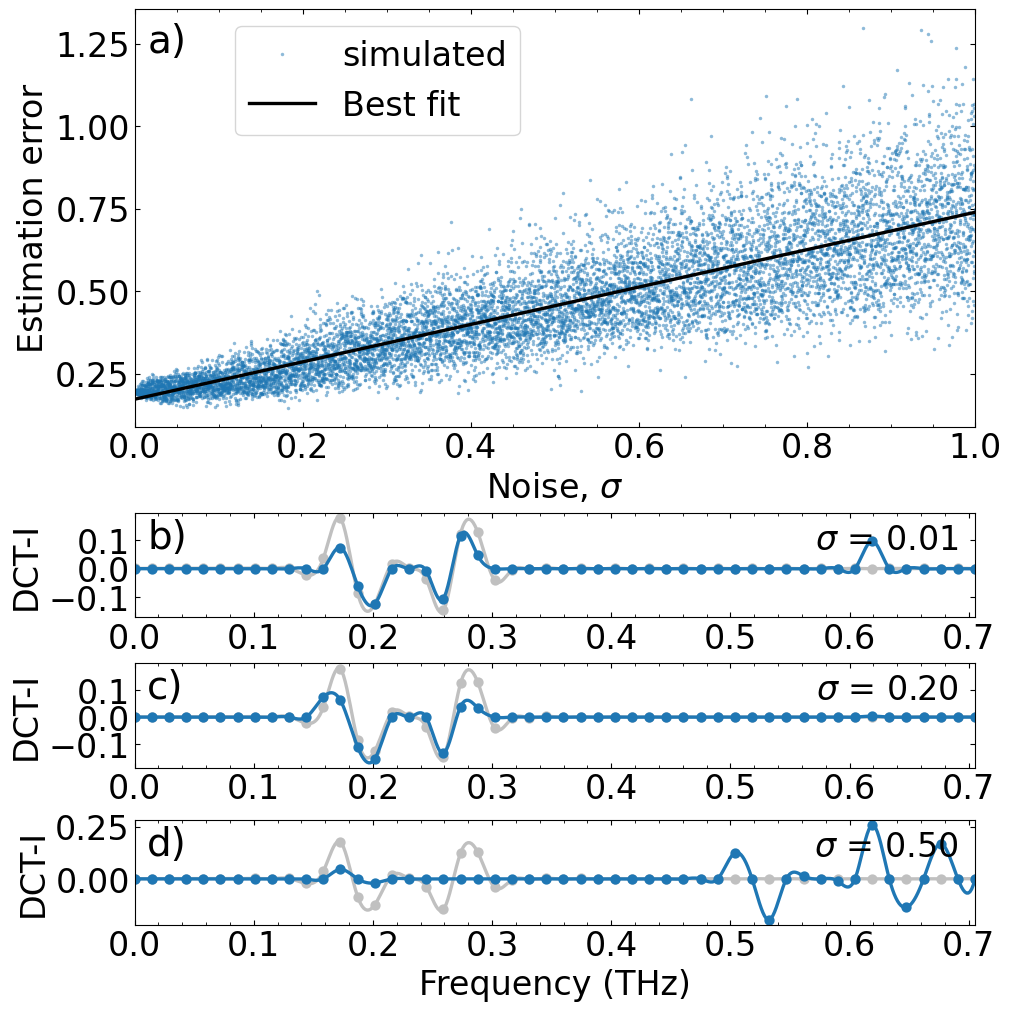

In [10]:
N = 10000; max_noise= 1.0; regularization_coeffient= 1e-2 #max_noise*1.3

noises = np.linspace(0, max_noise, N)
RSS = np.empty(N); L2 = np.empty(N); theory = np.empty(N)

examples = {"noise": [0.01, 0.2, 0.5],
            "reconstructed": [np.nan, np.nan, np.nan],
            "target": [np.nan, np.nan, np.nan],
            "error": [np.nan, np.nan, np.nan]}
allnoises = []

a = 0

for n, noise in enumerate(noises):
    c = 1
    tau = 2
    offset = 0.35

    #lambda_N = 2 *noise *np.sqrt( tau *np.log10(p) /len(test_config) )
    #print(regularization_coeffient, lambda_N)
    #regularization_coeffient = lambda_N

    allnoise = np.random.normal(0, noise,  total_points)
    allnoises += [allnoise] # save specific instance of noise
    noiseless = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta)
    target = noiseless +allnoise
    uncertainties = np.full_like(target, noise)
    if np.linalg.norm(allnoise[test_config], ord= np.inf) <= noise:
        a += 1

    RSS[n] = cs.evaluate_score(test_config, target, uncertainties, noiseless, regularization_coeffient= regularization_coeffient, error_type= "RSS")

    sample = np.full_like(target, np.nan)
    sample[detectors] = target[detectors]
    result_DCT = cs.compressed_sensing(sample, regularization_coeffient, domain= "DCT", dct_type= 1)
    result = cs.compressed_sensing(sample, regularization_coeffient, domain= "IDCT", dct_type= 1)
    noiseless_DCT = spfft.dct(noiseless, norm= "ortho", type= 1) /np.sqrt(total_points)
    target_DCT = spfft.dct(target, norm= "ortho", type= 1) /np.sqrt(total_points)
    L2[n] = cs.evaluate_score(test_config, target, uncertainties, noiseless, regularization_coeffient= regularization_coeffient, error_type= "L2")

    k = np.count_nonzero(np.abs(noiseless_DCT) > 1e-2)
    p = len(target_DCT)
    theory[n] = c *noise *np.sqrt( k *np.log10(p) /len(test_config) ) + offset

print(k, a/N)



best_fit = np.polyfit(noises, L2, 1)
print(best_fit)

for n, noise in enumerate(examples["noise"]):
    idx = np.argmin(np.hypot(noises -noise, L2 -(best_fit[-1] +best_fit[-2]*noise)))
    examples["noise"][n] = noises[idx]
    examples["error"][n] = L2[idx]

    noiseless = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta)
    target = noiseless +allnoises[idx]
    sample = np.full_like(target, np.nan)
    sample[detectors] = target[detectors]
    result_DCT = cs.compressed_sensing(sample, regularization_coeffient, domain= "DCT", dct_type= 1)
    noiseless_DCT = spfft.dct(noiseless, norm= "ortho", type= 1) /np.sqrt(total_points)
    examples["reconstructed"][n] = result_DCT
    examples["target"][n] = noiseless_DCT
[print(best_fit[-1] +best_fit[-2]*noise, error) for noise, error in zip(examples["noise"], examples["error"])]


fig, axs = plt.subplots(4, 1, figsize= (10, 10), height_ratios= (4, 1, 1, 1), layout= "constrained")

axs[0].plot(noises, L2, linestyle= "none", marker= ".", markersize= 5, markerfacecolor= "tab:blue", markeredgewidth= 0.0, alpha= 0.5, label= "simulated")
axs[0].plot(noises, best_fit[-1] +best_fit[-2]*noises, color= "k", label= "Best fit")
axs[0].set(ylabel= "Estimation error", xlabel= r"Noise, $\sigma$", xlim= (noises.min(), noises.max()))
axs[0].annotate("a)", (0.015,0.97), xycoords= 'axes fraction', ha= "left", va= "top", fontsize= 28)
axs[0].legend(loc= "upper left", bbox_to_anchor= (0.1,1))
#axs[0].hlines(0.2, 0, 1, transform= axs[0].get_yaxis_transform(), color= "gray")
#axs[0].grid()

freqs = 1 / (2*pixel_pitch*1e-3*(total_points-1)) *np.arange(total_points) # for DCT-I. in m^-1
freqs *= C / (2*np.sin(np.deg2rad(theta))) # use MZ geometery

for ax, reconstructed, target, noise, label in zip(axs[1:], examples["reconstructed"], examples["target"], examples["noise"], ["b)","c)","d)"]):
    ax.plot(freqs*1e-12, target, color= "silver", marker= ".", linestyle= "none")
    ax.plot(cs.interpolate(freqs*1e-12, "cubic"), cs.interpolate(target, "cubic"), color= "silver")
    ax.plot(freqs*1e-12, reconstructed, color= "tab:blue", marker= ".", linestyle= "none")
    ax.plot(cs.interpolate(freqs*1e-12, "cubic"), cs.interpolate(reconstructed, "cubic"), color= "tab:blue")
    ax.set(ylabel= "DCT-I", xlim= (freqs.min()*1e-12, freqs.max()*1e-12))
    ax.text(0.98, 0.9, r"$\sigma$ =" f" {noise:.2f}", transform= ax.transAxes, ha= "right", va= "top")
    ax.annotate(label, (0.015,0.95), xycoords= 'axes fraction', ha= "left", va= "top", fontsize= 28)
axs[3].set(xlabel= "Frequency (THz)")

fig.savefig("./graphs/noise_robustness.png", bbox_inches= "tight")
plt.show()

In [11]:
L2

array([0.19500141, 0.19456463, 0.19443552, ..., 0.87419894, 0.68270789,
       0.61781996], shape=(10000,))

In [12]:
np.count_nonzero(np.abs(examples["target"][0]) >= 1e-2)

np.int64(11)

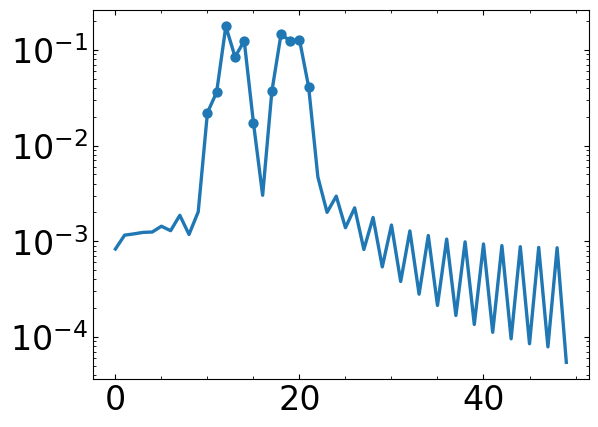

In [13]:
plt.plot(np.abs(examples["target"][0]))
plt.plot(np.where(np.abs(examples["target"][0]) >= 1e-2, np.abs(examples["target"][0]), np.nan), marker= ".", linestyle= "none", color= "tab:blue")
plt.yscale("log")

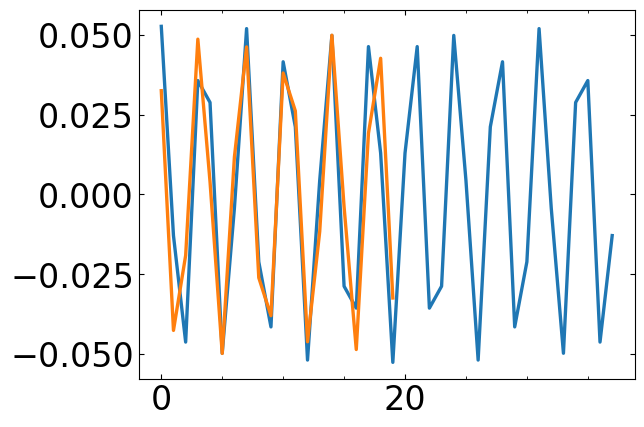

In [14]:
n = 11

a = np.zeros(20)
a[n] = 1

FFT = np.fft.irfft(a)
DCT = spfft.idct(a)

plt.plot(FFT)
plt.plot(DCT)

[0.14201944 0.08523378 0.11874023]
[ 0.13602118  0.2715916  -0.01009471]
[0.15033902 0.37829998 0.01364755]
[0.18168407 0.50069985 0.05163176]
[0.20499939 0.71974757 0.04101274]
[ 0.21228937  0.99498823 -0.03401612]
[ 0.22160156  1.15453667 -0.0360051 ]


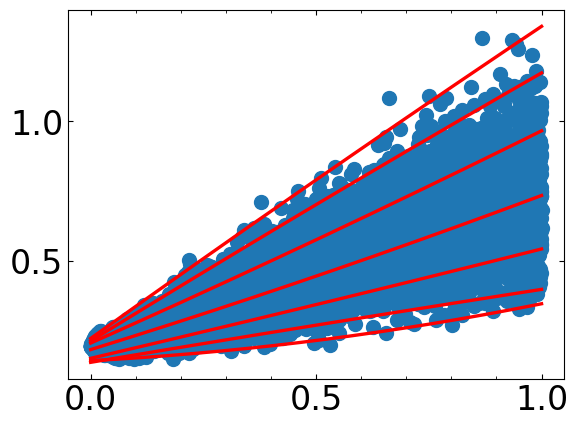

In [15]:
import statsmodels.api as sm
import numpy as np

# x and y are your data arrays
quantile = 0.99  # 99th percentile

X = np.column_stack([np.ones_like(noises), noises, noises**2]) # == X = np.array([np.ones_like(noises), noises, noises**2]).T
model = sm.QuantReg(L2, X)

fits = []
for quantile in [0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999]:
    res = model.fit(q=quantile)
    print(res.params)
    fit = res.predict(X)
    fits += [fit]

import matplotlib.pyplot as plt
plt.scatter(noises, L2)
for fit in fits:
    plt.plot(noises, fit, color='red')
#plt.plot(noises, theory, color= "k")
plt.show()

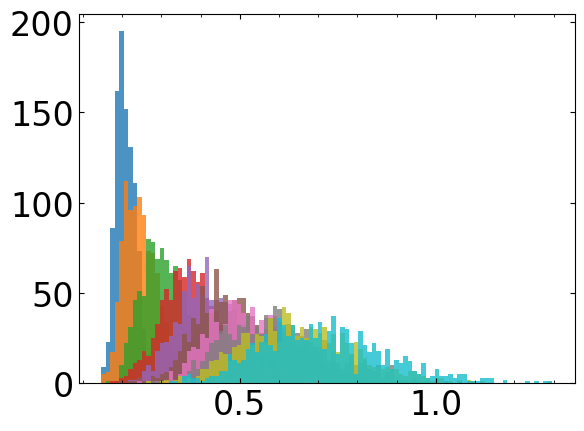

In [16]:
for n in np.arange(0.0, 1.1, 0.1):
    plt.hist(L2[(n < noises) & (noises <= n+0.1)], bins= 100, alpha= 0.8, range= (L2.min(), L2.max()))
plt.show()

0.01 0.0
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.01 0.00013035757934668713
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.01 0.00026071515869337426
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.01 0.00039107273804006137
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.01 0.0005214303173867485
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.01 0.0006517878967334356
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.01 0.0007821454760801227
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.01 0.0009125030554268098
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.01 0.001042860634773497
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.01 0.0011732182141201842
WARNING! Noiseless data not provided, assuming interferogram has no noi

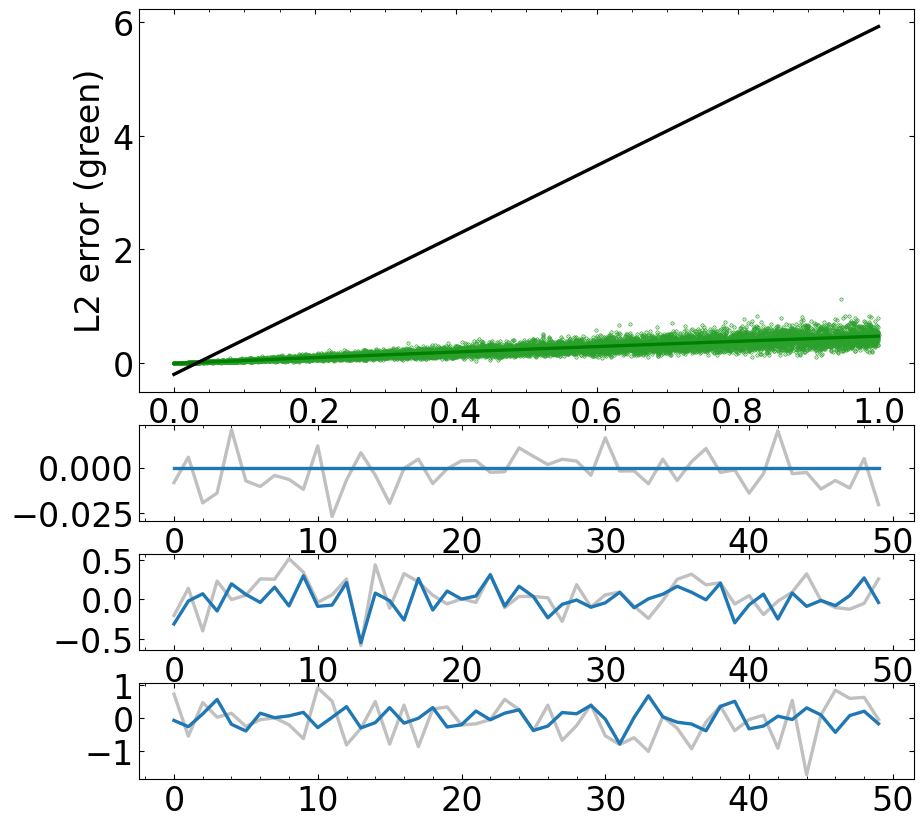

In [17]:
examples["reconstructed"] = []
examples["target"] = []

for n, noise in enumerate(noises):
    c = 5
    offset = -0.2
    tau = 2
    k = np.count_nonzero(np.abs(noiseless_DCT) > 1e-2)
    theory[n] = c *noise *np.sqrt( k *np.log10(np.e *len(target_DCT) /k) /len(test_config) ) + offset
    lambda_N = 2 *noise *np.sqrt( tau *np.log10(len(target_DCT)) /len(test_config) )
    print(regularization_coeffient, lambda_N)
    #regularization_coeffient = lambda_N

    allnoise = np.random.normal(0, noise,  total_points)
    zeros = np.zeros_like(allnoise)

    RSS[n] = cs.evaluate_score(test_config, allnoise, regularization_coeffient= regularization_coeffient, error_type= "RSS")

    sample = np.full_like(allnoise, np.nan)
    sample[detectors] = allnoise[detectors]
    result_DCT = cs.compressed_sensing(sample, regularization_coeffient, domain= "DCT", dct_type= 1)
    result = cs.compressed_sensing(sample, regularization_coeffient, domain= "IDCT", dct_type= 1)
    zeros_DCT = spfft.dct(zeros, norm= "forward", type= 1)
    allnoise_DCT = spfft.dct(allnoise, norm= "forward", type= 1)
    L2[n] = np.linalg.norm(result_DCT -zeros_DCT)

    for m in examples["noise"]:
        if m == noise:
            examples["reconstructed"] += [result]
            examples["target"] += [allnoise]
            print("Example saved!")
            

fig, axs = plt.subplots(4, 1, figsize= (10, 10), height_ratios= (4, 1, 1, 1))

axs[0].plot(noises, L2, color= "tab:green", linestyle= "none", marker= ".", markersize= 1)
axs[0].set(ylabel= "L2 error (green)")
best_fit = np.polyfit(noises, L2, 2)
print(best_fit)
axs[0].plot(noises, best_fit[-1] +best_fit[-2]*noises +best_fit[-3]*noises**2, color= "green")
axs[0].plot(noises, theory, color= "k")


for ax, reconstructed, target in zip(axs[1:], examples["reconstructed"], examples["target"]):
    ax.plot(target, color= "silver")
    ax.plot(reconstructed)

plt.show()

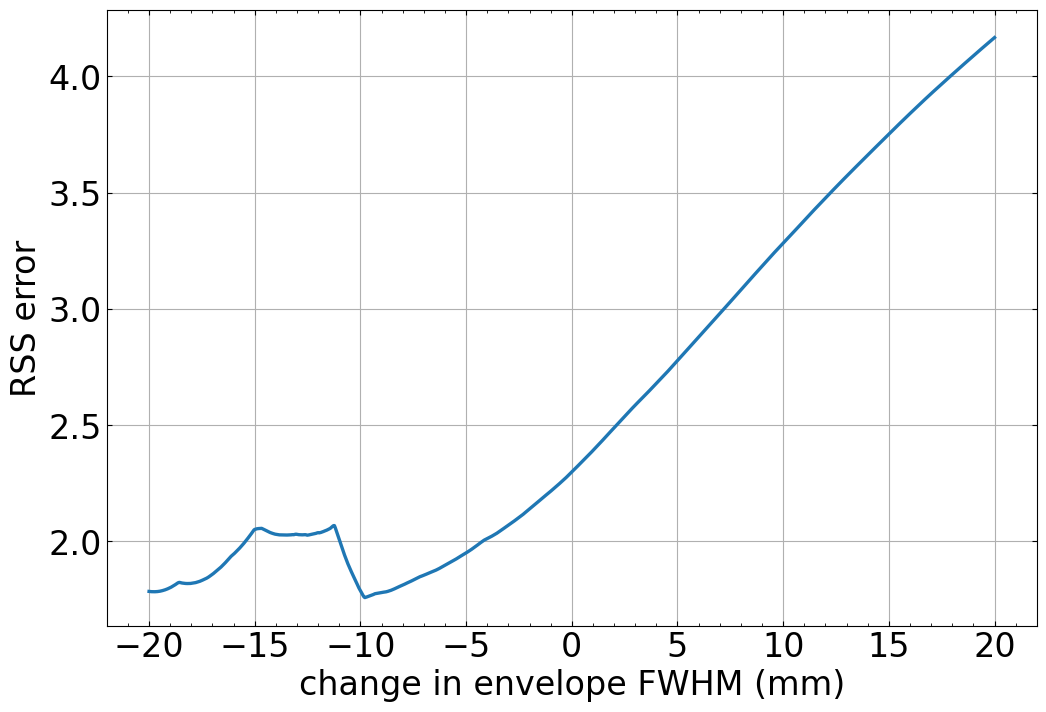

In [18]:
N = 1000; shift_range= 20
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, (envelope_FWHM +shift)*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts, scores)
axs.set(xlabel= r"change in envelope FWHM (mm)", ylabel= "RSS error")

plt.grid()
plt.show()

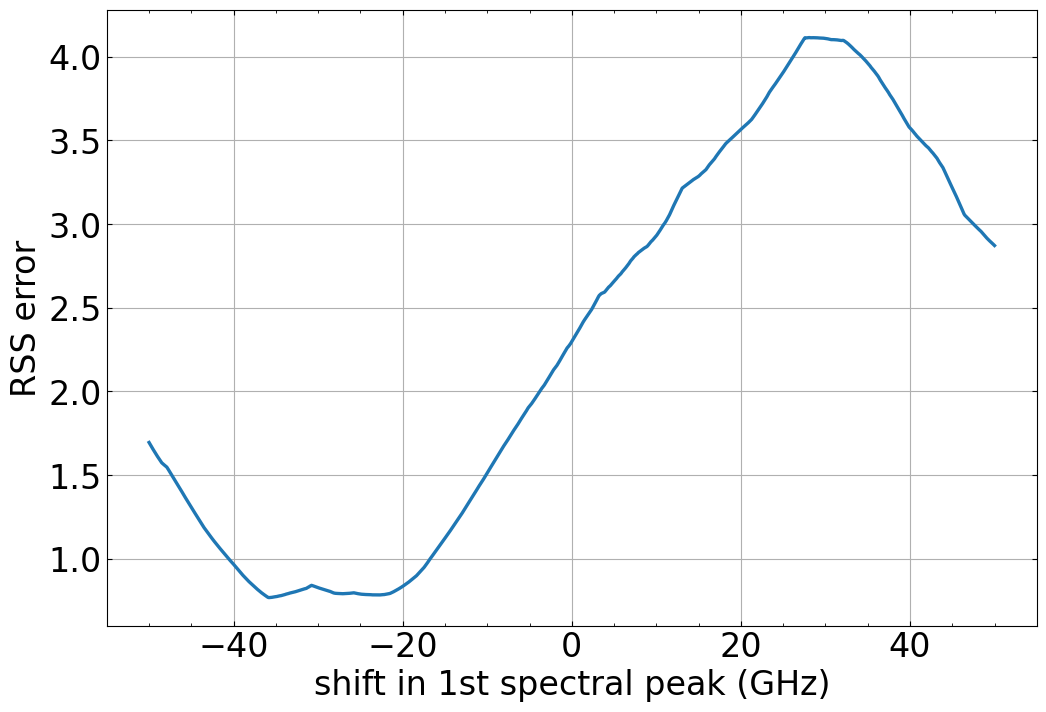

In [19]:
N = 1000; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, (peak_freqs[0]+shift, peak_freqs[1]), envelope_FWHM*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts*1e-9, scores)
axs.set(xlabel= "shift in 1st spectral peak (GHz)", ylabel= "RSS error")

plt.grid()
plt.show()

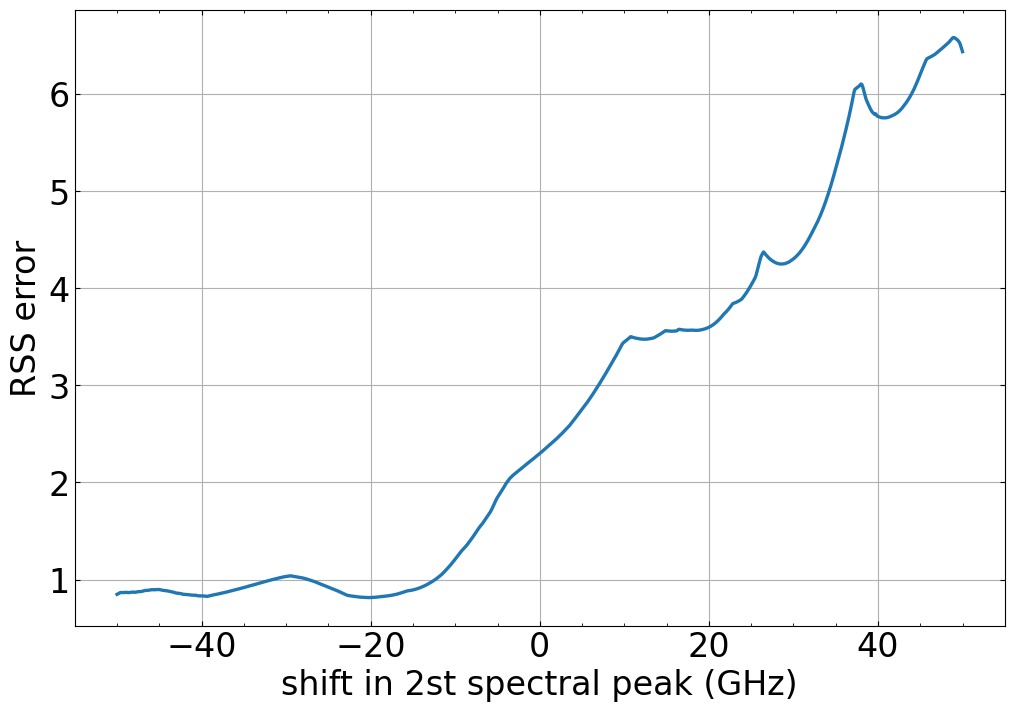

In [20]:
N = 1000; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, (peak_freqs[0], peak_freqs[1]+shift), envelope_FWHM*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts*1e-9, scores)
axs.set(xlabel= "shift in 2st spectral peak (GHz)", ylabel= "RSS error")

plt.grid()
plt.show()

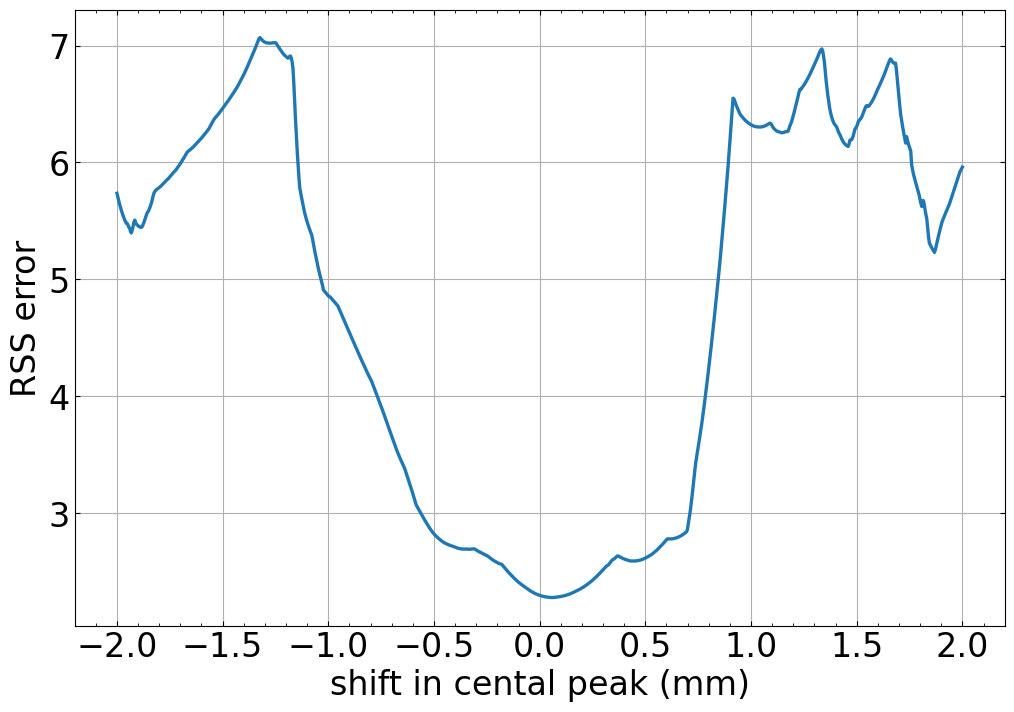

In [21]:
N = 1000; shift_range= 2
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta, displacement_shift= shift*1e-3)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts, scores)
axs.set(xlabel= "shift in cental peak (mm)", ylabel= "RSS error")

plt.grid()
plt.show()